In [12]:
#Import Libraries
# from google.colab import files
import pandas
import numpy as np
import matplotlib.pyplot as plt
import io
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import *
from sklearn.model_selection import KFold
from mpl_toolkits import mplot3d
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
import time

In [13]:
#physics guided initialisation Neural Network
#first task is euler beam solution to generate training data for our given geometry
#get I
def get_second_moment_of_area(width, height):
  b = width
  d = height
  Ixx = b*(d**3)/12 #about the horizontal axis
  Iyy = d*(b**3)/12 #about the vertical axis
  y = height/2 #return the y value to be used to compute the stress
  return Ixx, Iyy, y

#compute the moment, bending moment M = 1/2WZ^2, where w is the distributed load and z is the length of the beam
def get_moment(W, Z): #get the moment for a uniform pressure loading scenario
  M = 0.5*W*Z**2
  return M

#get the bending stress
def get_sigma(M, y, I):
  sigma = M*y/I
  return sigma

In [14]:
#these values are arbitrary, can be changed depending on how you desire to train the
#define the maximum length
L = 15
#define z coordinates
z = np.linspace(0,15,5)
#define the load 
W = 50
#define the ratio of z coordinate to length of beam 
zL = z/L
#get the bending moment values for each value of z 
M = get_moment(W, z)

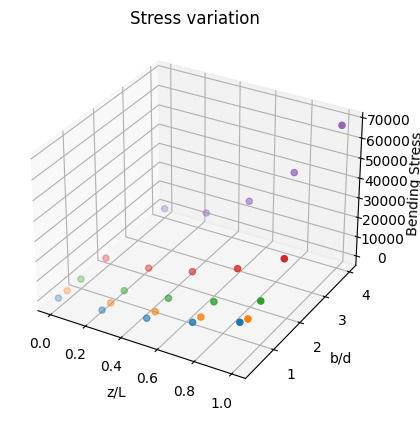

In [15]:
#define the range of cross section, with width b and height d
b = np.linspace(0.5,2,5)
d = np.linspace(2,0.5,5)
# ratio of width to height
bd = b/d
# ratio of width to length
bL = b/L

#compute the second moment of area, for a range of cross sections
#next compute the stresses for these second moments of areas
#the stress in a function of the width, height and length
# 3 parameters to fully define the stress
sig = []
Ix = []
for i in range(len(z)):
  Ixx, Iyy, y = get_second_moment_of_area(b[i],d[i])
  sigma = get_sigma(M, y, Ixx)
  sig.append(sigma)
  Ix.append(Ixx)


#visualize the stress and how it varies with the parameters
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.xlabel("z/L")
plt.title("Stress variation")
plt.ylabel("b/d")
ax.set_zlabel('Bending Stress')
for i in range(len(z)):
  ax.scatter3D(zL, bd[i], sig[i])

Text(0.5, 0.92, 'Stress as a a function of cross section')

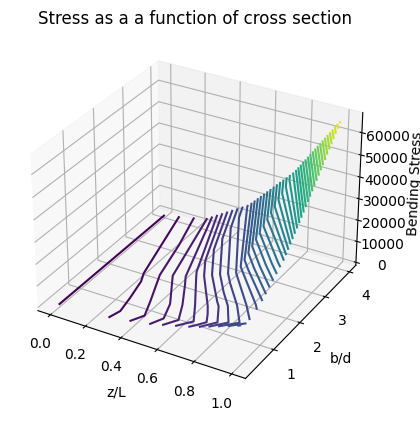

In [16]:
#visualize a 3D contour plot of the data
#3D contour plot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(zL, bd, sig, 50)
plt.xlabel("z/L")
plt.ylabel("b/d")
ax.set_zlabel('Bending Stress')
plt.title("Stress as a a function of cross section")

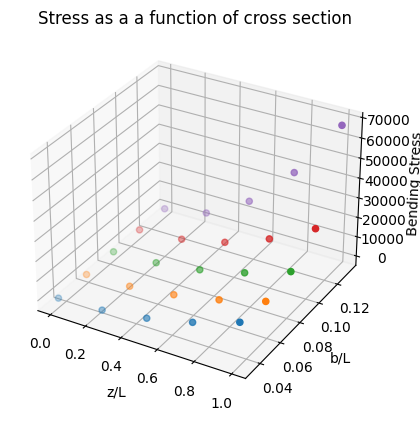

In [17]:
#generate a 3d plot containg bL
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.xlabel("z/L")
plt.ylabel("b/L")
ax.set_zlabel('Bending Stress')
plt.title("Stress as a a function of cross section")
for i in range(len(z)):
  ax.scatter3D(zL, bL[i], sig[i])

Text(0.5, 0.92, 'Stress as a a function of cross section')

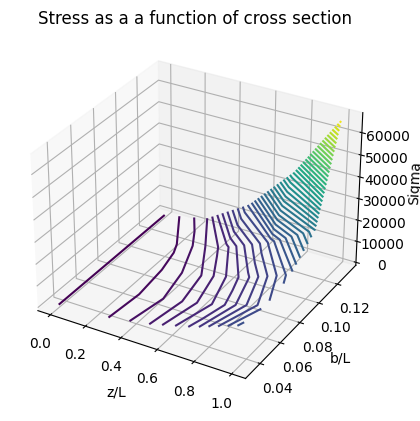

In [18]:
#3D contour plot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(zL, bL, sig, 50)
plt.xlabel("z/L")
plt.ylabel("b/L")
ax.set_zlabel('Sigma')
plt.title("Stress as a a function of cross section")

In [19]:
from sklearn.model_selection import train_test_split

# Stack the inputs arrays
input_data = np.stack([zL, bd, bL], axis=1)
input_data_normalized = (input_data - np.mean(input_data, axis=0)) / np.std(input_data, axis=0)
sig_normalized = (sig - np.mean(sig)) / np.std(sig)

# First split the data into a training set and a temporary set.
input_train, input_temp, sig_train, sig_temp = train_test_split(input_data_normalized, sig_normalized, test_size=0.3)

# Then split the temp_set into a validation set and a testing set.
input_val, input_test, sig_val, sig_test = train_test_split(input_temp, sig_temp, test_size=0.5)

model = Sequential()

# Add L2 regularization and dropout for the hidden layers
model.add(Dense(units=3, activation='gelu', input_dim=3, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=6, activation='gelu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=6, activation='gelu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=6, activation='gelu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='softplus'))

#learning rate
optimizer = Adam(lr=0.001)

# Compile the model
model.compile(loss="mean_squared_error", optimizer=optimizer)

start_time = time.time()

# Fit the data 
# Include validation data
history = model.fit(input_train, sig_train, epochs=10000, batch_size=64, validation_data=(input_val, sig_val))

end_time = time.time()



Epoch 1/10000
1/1 [==============================] - 1s 992ms/step - loss: 1.9357 - val_loss: 1.3322
Epoch 2/10000
1/1 [==============================] - 0s 28ms/step - loss: 1.9185 - val_loss: 1.3288
Epoch 3/10000
1/1 [==============================] - 0s 30ms/step - loss: 1.9242 - val_loss: 1.3253
Epoch 4/10000
1/1 [==============================] - 0s 35ms/step - loss: 1.9440 - val_loss: 1.3218
Epoch 5/10000
1/1 [==============================] - 0s 42ms/step - loss: 1.9144 - val_loss: 1.3185
Epoch 6/10000
1/1 [==============================] - 0s 37ms/step - loss: 1.9205 - val_loss: 1.3153
Epoch 7/10000
1/1 [==============================] - 0s 29ms/step - loss: 1.9186 - val_loss: 1.3120
Epoch 8/10000
1/1 [==============================] - 0s 38ms/step - loss: 1.9222 - val_loss: 1.3088
Epoch 9/10000
1/1 [==============================] - 0s 28ms/step - loss: 1.9304 - val_loss: 1.3055
Epoch 10/10000
1/1 [==============================] - 0s 31ms/step - loss: 1.8982 - val_loss: 1.302

In [20]:
# Calculate execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

# Evaluate the model on the test set
test_loss = model.evaluate(input_test, sig_test, verbose=0)
print(f"Test loss: {test_loss}")


Execution time: 319.32433009147644 seconds
Test loss: 0.6187795400619507


4/4 [==============================] - 0s 1ms/step


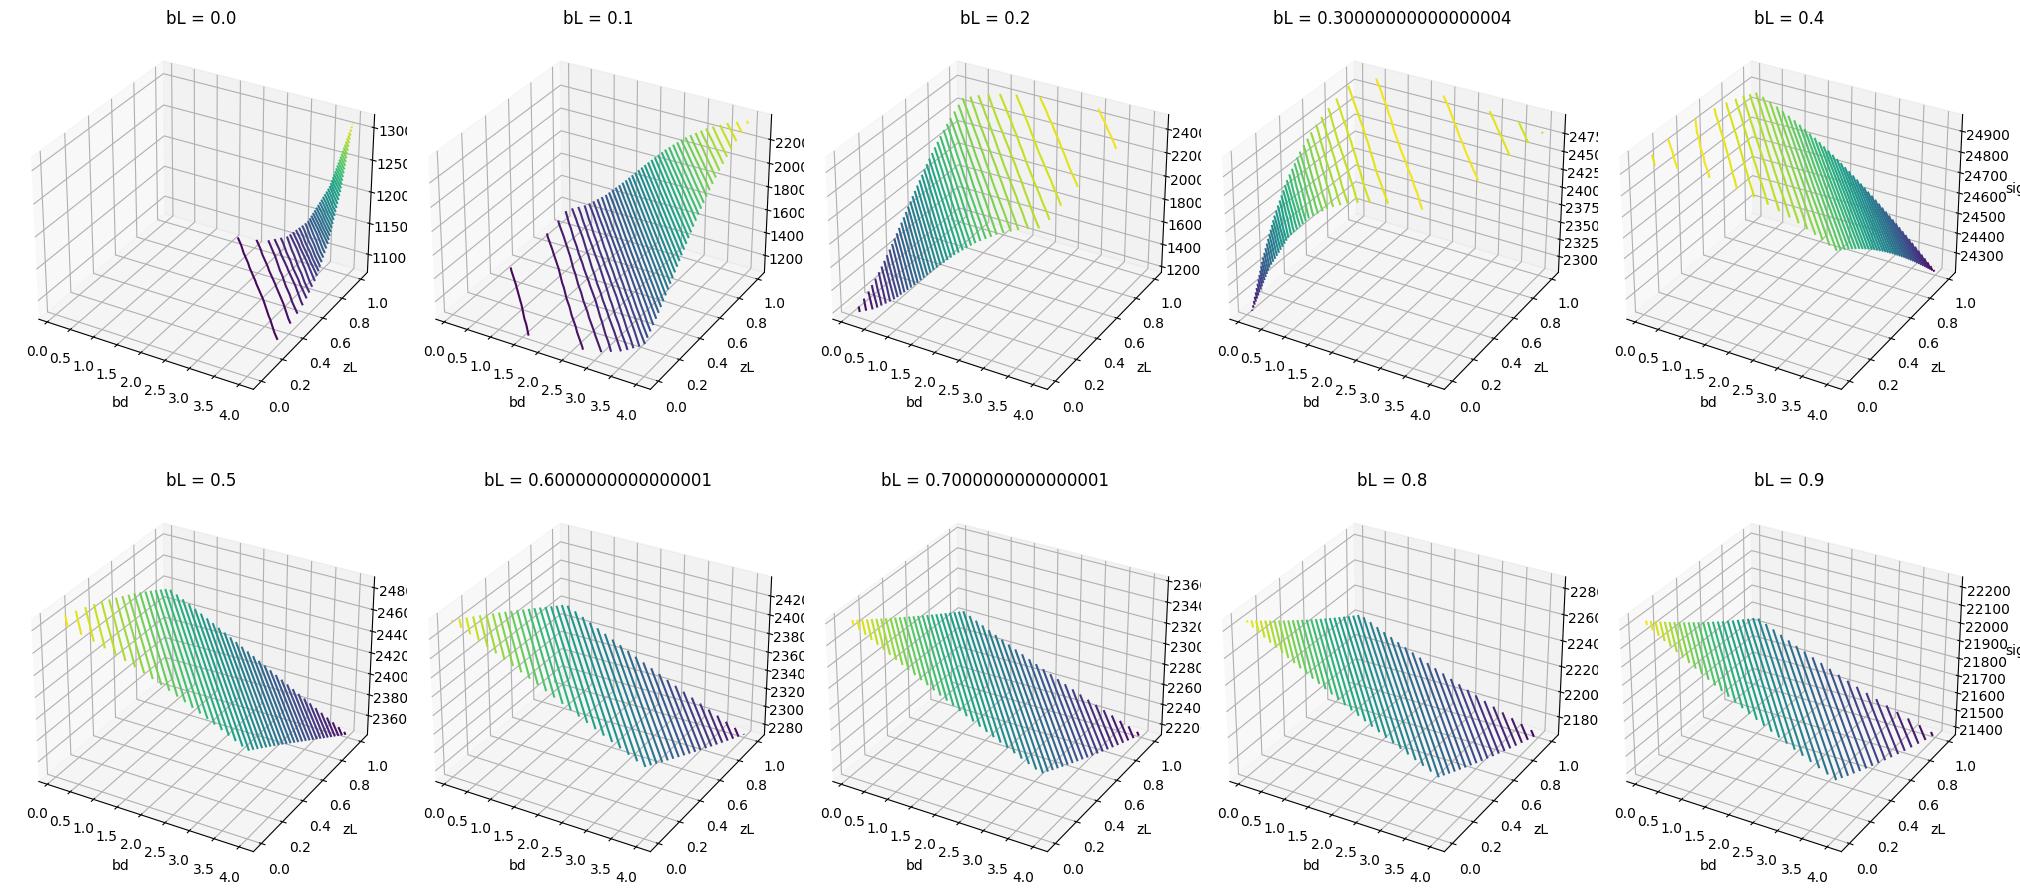

In [21]:
# Stack the test input data and normalize
bdtest = np.linspace(0.1,4,10)
zLtest = np.linspace(0,1,10)
bLtest = np.linspace(0,0.9,10)


# Create grid for 3D plot
bd_grid, zL_grid = np.meshgrid(bdtest, zLtest)

# reshape to make 1D arrays
bd_1d = bd_grid.ravel()
zL_1d = zL_grid.ravel()

# Training data mean and std for de-normalization
input_data_mean = np.mean(input_data, axis=0)
input_data_std = np.std(input_data, axis=0)
sig_mean = np.mean(sig)
sig_std = np.std(sig)

# Define number of rows and columns
n_rows = 2
n_cols = 5

fig = plt.figure(figsize=(20, 10))

for i in range(len(bLtest)):
    ax = fig.add_subplot(n_rows, n_cols, i+1, projection='3d')

    # Predict the sig values for each bL
    input_data_test = np.stack([zL_1d, bd_1d, np.full_like(zL_1d, bLtest[i])], axis=1)
    input_data_test_normalized = (input_data_test - input_data_mean) / input_data_std

    predicted_sig_normalized = model.predict(input_data_test_normalized)

    # De-normalize the predicted sig values
    predicted_sig = predicted_sig_normalized * sig_std + sig_mean

    Z = predicted_sig.reshape(bd_grid.shape)

    # Make contour plot
    ax.contour3D(bd_grid, zL_grid, Z, 50, cmap='viridis')

    ax.set_xlabel('bd')
    ax.set_ylabel('zL')
    ax.set_zlabel('sig')
    ax.set_title(f'bL = {bLtest[i]}')

plt.tight_layout()
plt.show()